In [26]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [27]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)



['unsup',
 'urls_neg.txt',
 'unsupBow.feat',
 'neg',
 'urls_unsup.txt',
 'urls_pos.txt',
 'pos',
 'labeledBow.feat']

sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())


In [28]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)


Found 50012 files belonging to 3 classes.
Using 40010 files for training.


In [29]:
for text_batch, label_batch in raw_train_ds.take(2):
  for i in range(4):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])


Review b'I\'m a recent convert to IMDb and have been writing and posting these comments since late November and they\'ve mostly been about films. No television show has really motivated and impressed me enough to compose a love letter in it\'s honour so far. Until I decided this little (only in ratings) wonder deserved the distinction of becoming the first program I\'d praise to the skies.<br /><br />I checked the chronological filter in reverse to find out just who was the very first soul to write here about "Freaks and Geeks". I wanted to give them a tip of the hat by name. And guess what? The comment from 19 July 1999 (love the way those numbers flow together) was listed as "anonymous"! Oh, well. Thanks anyway, whoever you are. <br /><br />I assumed by now there would be over 1000 people on this subject and was shocked there are less than 200 so far! Where are all you "freaks" and "geeks"? Write something and tell the world out there that this show is easily one of the greatest of t

In [30]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])


Label 0 corresponds to neg
Label 1 corresponds to pos


In [31]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 50012 files belonging to 3 classes.
Using 10002 files for validation.


In [32]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [33]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [34]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [35]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [36]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [37]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"Although this story is relatively confined to a simple bar set I found the characters that enter the scene are very animated and entertaining. The level headed owner/bartender keeps everything in order but the antics do fly. A refreshing look at the expressive character types of the 40's. Not much in terms of complex plot twists or symbolic messages just a funfilled look at a bar/lounge of that time period.", shape=(), dtype=string)
Label unsup
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 269,   10,   64,    7, 2230, 6647,    6,    4,  597, 1538,  287,
          11,  248,    2,  100,   12, 2351,    2,  128,   22,   52, 1318,
           3,  393,    2,  630, 4015,    1,  905,  282,    8,  623,   18,
           2, 3022,   82, 1753,    4, 2238,  164,   30,    2, 7147,  105,
        2083,    5,    2, 3365,   23,   71,    8, 1250,    5, 1233,  111,
        1273,   41, 5591, 3933,   40,    4,    1,  164,   30,    4,    1,
           5,   12,  

In [38]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  pictures
 313 --->  excellent
Vocabulary size: 10000


In [39]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [41]:
embedding_dim = 16

In [42]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [44]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
1251/1251 [==============================] - 18s 14ms/step - loss: -17.6629 - binary_accuracy: 1.4996e-04 - val_loss: -51.6525 - val_binary_accuracy: 1.9996e-04
Epoch 2/10
1251/1251 [==============================] - 6s 5ms/step - loss: -112.8837 - binary_accuracy: 1.4996e-04 - val_loss: -186.3475 - val_binary_accuracy: 1.9996e-04
Epoch 3/10
1251/1251 [==============================] - 6s 5ms/step - loss: -279.1162 - binary_accuracy: 1.4996e-04 - val_loss: -382.5068 - val_binary_accuracy: 1.9996e-04
Epoch 4/10
1251/1251 [==============================] - 6s 5ms/step - loss: -501.2136 - binary_accuracy: 1.4996e-04 - val_loss: -630.9420 - val_binary_accuracy: 1.9996e-04
Epoch 5/10
1251/1251 [==============================] - 6s 5ms/step - loss: -774.5911 - binary_accuracy: 1.4996e-04 - val_loss: -928.2136 - val_binary_accuracy: 1.9996e-04
Epoch 6/10
1251/1251 [==============================] - 6s 5ms/step - loss: -1093.9227 - binary_accuracy: 1.4996e-04 - val_loss: -1272.0964 

In [45]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 6s 8ms/step - loss: 1558.5760 - binary_accuracy: 0.5000
Loss:  1558.5760498046875
Accuracy:  0.5


In [46]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

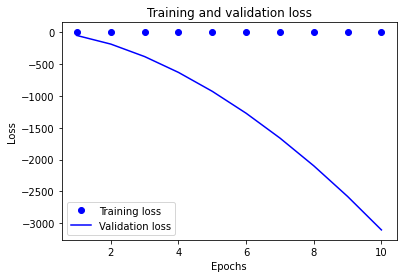

In [50]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [48]:
!rm -rf aclImdb/train/neg/*

In [49]:
!rm -rf aclImdb/train/pos/*